# Introduction to topic modeling with DL

In this exercise, I explore topic modeling with transfer learning applied to NLP. The goal is to show how to leverage pre-trained models in clustering for topic modeling. As we saw before, topic modeling is a form of unsupervised modeling with the goal of clustering similar samples (documents) together to form groups. The groups of documents are then labeled using by extracting topics from the clusters.

In this exercise, we reproduce/develop a methodology similar to BertTopic and Top2vec that leverages pre-trained embedding DL models.  We use the 20newsgroup dataset which is a benchmark data used in text classification to assess the quality of the topic modeling method. Instead of using the labels from the 20 newsdataset, we cluster the samples/docuemnts as if the dataset was unlabeled. The general step by step workflow is as follow:

- embedding: BERT/sentence encoding or Universal Sentence Encoder
- dimension reduction: UMAP
- clustering: HDBSCAN
- labeling: cluster tf-idf

We describe in more details the various steps below.

## Embedding

Text must be tokenized: turn words or sentences into a numerical format before performing any modeling.
We used a pre-trained embedding model to convert our text into a vector space. For this exercise, we use Universal Sentence Encoder (USE) from tensforflow hub. The output of the encoder is a 512 vector space. Taken together, dimensions of the 512 vector space correspond to a feature space that allows to map the meanings and semantic relationship between words or sentences.

## Dimension reduction

The embedding creates a very large encoding of text and this high dimension is often problematic for clustering algorithms. To reduce the dimension of the embedding there are multiple existing methods such as Principal Component Analysis (PCA) or Uniform Manifold Approximation and Projection (UMAP). Recent literature has shown that UMAP works well and has less constraints than PCA. As is done in BerTopic and Top2vec, we use UMAP to reduce the dimension of the feature space.

## Clustering

Clustering is the process of grouping similar text samples together. There are different algorithms available such as Kmeans and DSBCAN. In this exercise, we use HDBSCAN (Hierarchical Density Based Spatial Clustering of Applications with Noise). HDBSCAN is is a variant of DSBCAN that consider multiple spatial scales in the clustering. The algorithm does not require any assumption (spherical cluster like Kmeans for instance) as is robust to outliers/noise.

## Labeling

Once the groups or clusters have beeen create, we have to label each groups with a topic based on its characteristic. There are multiple strategies available:
- extract topics using word occurence or tf-idf of clusters
- extract topics based on the closeness to the mean vector or centroid of the clsuters.

We explore cluster tf-idf and centroid based topic vector.

## Dataset

The 20newsgroup dataset is a popular benchmark dataset used in NLP. It was originally used in a publication by Ken Lang published in 1995. It was later used in made available in kaggle and other repository. It contains almost 20,000 newsgroup documents labeled as 20 topics.


Useful links:

- twitter sentiment airlines data:

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

- Universal Sentence Encoder with tensorflow:

https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
paper: https://arxiv.org/abs/1803.11175

- transformers:

https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452

- BERT: bert paper: https://arxiv.org/abs/1810.04805

- https://towardsdatascience.com/bertopic-what-is-so-special-about-v0-16-64d5eb3783d9

- http://top2vec.rtfd.io
D. Angelov, Top2Vec: Distributed Representations of Topics, (2020), arXiv.org.

- L. McInnes, J. Healy, and J. Melville, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, (2020), arXiv.org.

- C. Malzer and M. Baum, A Hybrid Approach To Hierarchical Density-based Cluster Selection, (2021), arXiv.org.https://github.com/lmcinnes/umap
Topic Modeling
Top2vec
Hdbscan
Umap

comparing clustering algorithm:

https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

https://michael-fuchs-python.netlify.app/2020/06/20/hdbscan/


- https://pnlpuos.github.io/topic-modeling


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

In [2]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.13 #specific version needed for BERT

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)


In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.5 MB/s eta 0:00:00


In [4]:
!pip install np_utils

  Using cached np_utils-0.6.0.tar.gz (61 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=f989925b7a7e6d5eaf669b1e54db7de61eddf7dcc9d1f3e86c8fb447366e3f2c
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [5]:
###### Library used in this script
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob

#ML imports
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#Keras import
from tensorflow import keras
#from keras.models import Model
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


#from tensorflow.keras.utils import np_utils
import np_utils
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

#Please download the below also. This will resolve your issue:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#nltk.download('omw-1.4'*)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
!pip install umap-learn
#https://github.com/MaartenGr/BERTopic/issues/1450
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=b98f24aa3313ab6e43c0eb145fc306c1a1c4e4b23a1f9a6f7d10603af87838d8
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039287 sha256=d60761b2e8143a1647c841cadffaca7872b8afc15145becbedeb87f7ecbb2c72
  S

In [8]:
import umap as umap
import hdbscan

In [9]:
sklearn.__version__

'1.2.2'

In [10]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [11]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

* **create_dir_and_check_existence**:  create and output directory given a path. The output directory will be the working directory throughout the analysis.


In [12]:
def create_dir_and_check_existence(path):

    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

from matplotlib import pyplot

In [13]:
def clean_text(data):

    import re

    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()

    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")

    #5. Tokenize
    text_tokens = word_tokenize(data.lower())

    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    #7. Removing Stopwords
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
            stop_words.remove(i)
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]


    #joining
    return " ".join(text_cleaned)

In [14]:
#pulled from tensorflow tutorial and more
#https://stackoverflow.com/questions/70854665/tensorflow-textvectorization-convert-the-predicted-text-back-to-a-human-readabl

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<\b>' ,' ')
  return tf.strings.regex_replace(stripped_html,'[%s#@]' % re.escape(string.punctuation),'')

def normalize(text):
  remove_regex = f'[{re.escape(string.punctuation)}]'
  space_regex = '...'
  result = tf.strings.lower(text)
  result = tf.strings.regex_replace(result, remove_regex, '')
  result = tf.strings.regex_replace(result, space_regex, ' ')
  return result

In [15]:
#https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [16]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/data'
out_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/'

out_suffix = 'topic_modeling_dl_2024-03-06'
random_seed= 42
create_out_dir = True

#ARG 7
## Input data
data_dir = '/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/data/'
#ARG 8
run_model = False #if True, model is trained, note this may take several hours.

#ARG 9
# Use pre-trained model if run_model is False
model_path = None
#model_path ='/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_embedding_nlp/'

In [17]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


directory already exists


In [18]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/outputs/output_data_topic_modeling_dl_2024-03-06


In [19]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/outputs/output_data_topic_modeling_dl_2024-03-06


#0.Workflow/pipeline

We describe here the modeling pipeline we set up for this exercise:
1. **Load and explore data**
- Obtain data sklearn
- Quick exploration of 20 newsgroups dataset
2. **Embedding**
- Using universal sentence encoder for text vectorization
3. **Dimension reduction**
- exploring UMAP
- reducing dimensions
4. **Clustering**
- exploring HDBSCAN
- performing clustering
5. **Labeling**
- generate labels from cluster word counts
- generate labels from cluster tfidf
6. **Cluster evaluation**
- exploring extrensic and intrisic metrics
- computing evaluation metrics for clustering
7. **Conclusions**
- summarizing results
- future improvements

# 1.Load and explore data

The 20newsgroup dataset is a popular benchmark dataset used in NLP. It was originally used in a publication by Ken Lang published in 1995. It was later used in made available in kaggle and other repository. It contains almost 20,000 newsgroup documents labeled as 20 topics.

We use sklearn to access the 20 newsgroup dataset.

Useful links:

- https://medium.com/@datailm/text-classification-mastery-a-step-by-step-guide-using-the-20-newsgroups-dataset-a0a56fc245e0

- https://dylancastillo.co/clustering-documents-with-openai-langchain-hdbscan/
- https://www.kaggle.com/code/aybukehamideak/clustering-text-documents-using-k-means
- https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py


In [20]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [21]:
import tensorflow as tf
print(tf.__version__) #should use higher tensorflow!!!

2.13.0


In [22]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
print(type(newsgroups))
# Create a DataFrame from the dataset
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})

# Get labels for the documents
df['label'] = df['label'].map(lambda x: newsgroups.target_names[x])
print(df.shape)
print(df['label'].nunique())
df['label'].value_counts()

<class 'sklearn.utils._bunch.Bunch'>
(18846, 2)
20


rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             996
rec.sport.baseball          994
sci.crypt                   991
rec.autos                   990
sci.med                     990
comp.windows.x              988
sci.space                   987
comp.os.ms-windows.misc     985
sci.electronics             984
comp.sys.ibm.pc.hardware    982
misc.forsale                975
comp.graphics               973
comp.sys.mac.hardware       963
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: label, dtype: int64

Our goal is to better understand topic modeling with Deep Learning so we reduce the complexity of the dataset by selecting only 4 topics from the 20 topics available in the 20newsgroup dataset:

- science-space
- talks-politics
- recreative-sport-baseball

In [23]:
selected_topics = ['sci.space','talk.politics.misc','rec.sport.baseball','comp.windows.x']
df = df.loc[df['label'].isin(selected_topics)]
print(df['label'].value_counts())
df.shape

rec.sport.baseball    994
comp.windows.x        988
sci.space             987
talk.politics.misc    775
Name: label, dtype: int64


(3744, 2)

The subset of 20news groups now contains 3744 rows. It's balanced wtih slighly less documents on the topic 'talk-politcs'.

In [24]:
df.head()

,text,label
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",comp.windows.x
25,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this? How much, to attend????\n\nAnyone want to go?",sci.space
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",comp.windows.x
33,\nBe patient. He has a sore shoulder from crashing into the wall.\nThe Cards will give him all the time he needs to come around.\nHe is their full time centerfielder.\nHe will not however steal as often this year as he is hitting\nclean-up.,rec.sport.baseball
37,\n\tProof that the entire private sector is vastly more inefficient?\n\n\n\tBlue Cross is the government health insurance provider.\n\n\tOops.\n\n\t[Ads for Z magazine deleted to Save the Earth],talk.politics.misc


#2. **Embedding**

To vectorize the text, we use Universal Sentence Encoder (USE) from tensorflow hub. It is a pre-trained model embedding published in 2018. USE encode sentences but can take input of any size.

It performs well on many tasks when fine tuned.  USE also tries to tackle bias in the data (racial, gender etc.) and performs well on the Word Embedding Association Tests (WEAT).

We use the weights from USE version 4 accessible via this URL:
- "https://tfhub.dev/google/universal-sentence-encoder/4"

Useful links:
- https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

- https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html

- https://krishnakshirsagar87.medium.com/text-classification-with-universal-sentence-encoder-b4bb471cc0af


In [25]:
from absl import logging
import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [26]:
import tensorflow_hub as hub

tfhub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedding_use = hub.load(tfhub_url) # load Universal Sentence Encoder
embedding_use

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7a7f90bc96f0>

In [ ]:
corpus = [
'@john, I like baseball',
'I love baseball especially batting',
'I use linux rather than windows',
'My os is open source',
'#participate, elections are taking place in two weeks',
'The senate should vote on this motion',
]

In [ ]:
embedded_text = embedding_use(corpus)
embedded_text

<tf.Tensor: shape=(6, 512), dtype=float32, numpy=
array([[ 0.01276491, -0.02501938, -0.05928737, ...,  0.01738831,
        -0.0141086 ,  0.03998813],
       [ 0.00096526,  0.02050705, -0.04871426, ..., -0.04666071,
        -0.07232241, -0.04692477],
       [-0.01414567, -0.02852671,  0.01871562, ...,  0.00488818,
        -0.03652943, -0.03138123],
       [-0.03905844, -0.01882505, -0.00536263, ...,  0.01108819,
        -0.05079075, -0.00850757],
       [-0.06950773, -0.07787099,  0.00537366, ...,  0.00710229,
        -0.02744536,  0.02613232],
       [ 0.04325299, -0.06937122, -0.00065101, ..., -0.04975071,
         0.0336398 ,  0.01411583]], dtype=float32)>

Let's compute the inner product wich correspond to the cosine similarity. We find that sentence 1 and sentence 2 are related as expected.

In [ ]:
corr = np.inner(embedded_text, embedded_text)
pd.DataFrame(corr)

,0,1,2,3,4,5
0,1.000000,0.585114,0.003104,0.049160,0.028214,0.132847
1,0.585114,1.000000,0.051937,0.049487,0.019841,0.007329
2,0.003104,0.051937,1.000000,0.498492,0.065784,-0.039394
3,0.049160,0.049487,0.498492,1.000000,0.074944,-0.016426
4,0.028214,0.019841,0.065784,0.074944,1.000000,0.198288
5,0.132847,0.007329,-0.039394,-0.016426,0.198288,1.000000


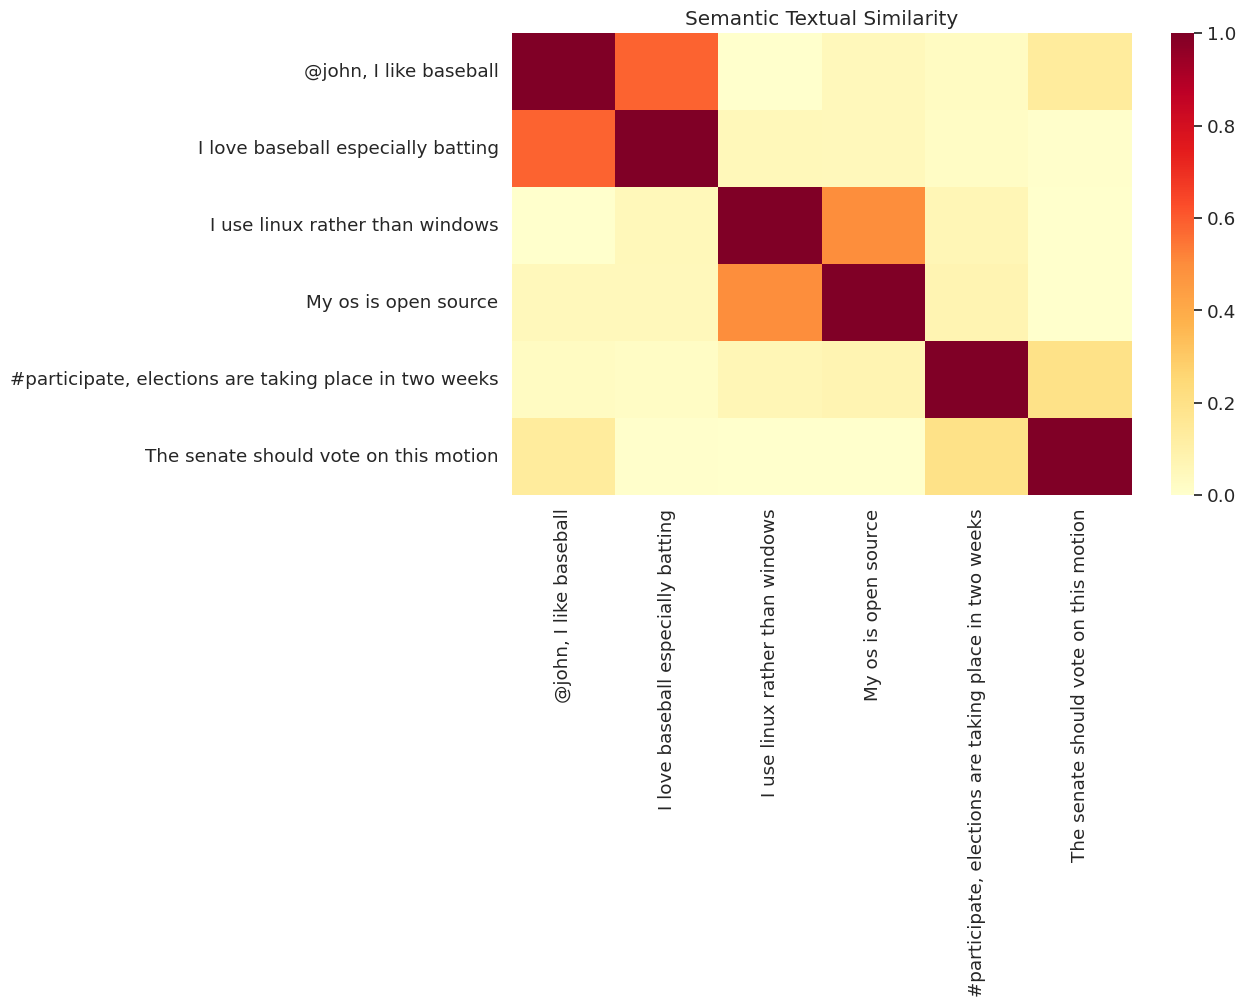

In [ ]:
run_and_plot(corpus)

The mock up dataset consists in 6 sentences with a variety of length with some unusual characters (# and @). We can see that the sentences that are similar show strong cosine similarity.

Let's now apply this to our dataset.

In [27]:
print(type(df['text'].values[0]))
df['text'].values[0]

<class 'str'>


"\nSorry, that's a feature.  The ICCCM specifies how the app should set its title, so the wm is obliged to do it.  If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM.  Or write an program that you give a window ID and a title.  The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n"

Let's convert our documents to list of text as input into USE.

In [28]:
list_text = df['text'].to_list()
print(len(list_text))
list_text[1:2]

3744


['AW&ST  had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th  at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this?  How much, to attend????\n\nAnyone want to go?']

We can embedde each document in USE using the instantiated encoding layer. This produces a 3744x512 tensorflow.

In [29]:
embedded_text = embedding_use(list_text)
embedded_text

<tf.Tensor: shape=(3744, 512), dtype=float32, numpy=
array([[ 0.06064681, -0.03505683, -0.04552798, ...,  0.05488847,
         0.00108737, -0.0111248 ],
       [-0.05406706, -0.02499637,  0.00398008, ..., -0.01830359,
        -0.02077572, -0.03779927],
       [-0.06712257, -0.03160696, -0.06027848, ..., -0.00983679,
         0.04648712, -0.02257958],
       ...,
       [-0.00400411, -0.07042237, -0.04526532, ...,  0.0014028 ,
        -0.00606017,  0.01055343],
       [-0.01874406, -0.03414074,  0.00079914, ...,  0.0614885 ,
        -0.03676056,  0.00904108],
       [-0.00728451, -0.01814894,  0.00287411, ..., -0.03475184,
        -0.04445034, -0.08088386]], dtype=float32)>

#3. **Dimension Reduction: UMAP**

Next, we reduce the embedded text for visualization and clustering purpose. We use Uniform Manifold Approximation and Projection (UMAP).


Useful links:

- https://github.com/MaartenGr/BERTopic/issues/381
- https://umap-learn.readthedocs.io/en/latest/clustering.html
- https://www.kdnuggets.com/2020/11/topic-modeling-bert.html

In [31]:
#should probably use cosine distance for UMAP!!
print(type(embedded_text))
umap_reducer = umap.UMAP(random_state=random_seed,
                         n_neighbors=15,
                         n_components=5)
data_reduced = umap_reducer.fit(embedded_text).embedding_
print(type(data_reduced))
print(data_reduced.shape)
data_reduced

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
(3744, 5)


array([[ 9.101386  ,  8.7140045 ,  6.53433   ,  5.4296713 ,  8.452743  ],
       [ 9.828114  ,  9.640916  ,  3.5505004 ,  1.1276201 ,  7.6533613 ],
       [ 9.627604  ,  8.583593  ,  5.349267  ,  4.642809  ,  8.489208  ],
       ...,
       [ 9.156731  ,  8.132255  ,  6.4179206 ,  4.9274473 ,  8.86507   ],
       [11.355236  , 10.013823  ,  1.1202905 ,  2.091362  ,  8.087641  ],
       [10.579773  , 10.4896345 , -0.99621236,  5.9285145 ,  7.0995746 ]],
      dtype=float32)

In [ ]:
'''
#https://github.com/PNLPUOS/PNLPUOS/blob/master/pnlp/notebooks/topic_clustering/topic_clustering_word2vec_13.ipynb

# Perform UMAP dimensionality reduction to more cleanly separate clusters and improve performance.
reducer = umap.UMAP(random_state=42, min_dist=0.0, spread=5, n_neighbors=19)
data_reduced = reducer.fit(data).embedding_
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
plt.show()
'''

"\n#https://github.com/PNLPUOS/PNLPUOS/blob/master/pnlp/notebooks/topic_clustering/topic_clustering_word2vec_13.ipynb\n\n# Perform UMAP dimensionality reduction to more cleanly separate clusters and improve performance.\nreducer = umap.UMAP(random_state=42, min_dist=0.0, spread=5, n_neighbors=19)\ndata_reduced = reducer.fit(data).embedding_\nplt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')\nplt.show()\n"

#4. HDBSCAN

https://pypi.org/project/hdbscan/

In [32]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean')
cluster.fit(data_reduced)
print(len(cluster.labels_))

3744


In [33]:
print(type(cluster.labels_))
print(np.unique(cluster.labels_))

<class 'numpy.ndarray'>
[0 1 2 3]


In [34]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean')
cluster.fit(data_reduced)
print(len(cluster.labels_))
print(type(cluster.labels_))
print(np.unique(cluster.labels_))

3744
<class 'numpy.ndarray'>
[0 1 2 3 4]


In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=25,
                          metric='euclidean')
cluster.fit(data_reduced)
print(len(cluster.labels_))
print(type(cluster.labels_))
print(np.unique(cluster.labels_))

3744
<class 'numpy.ndarray'>
[-1  0  1  2]


In [35]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean')
cluster.fit(data_reduced)
print(len(cluster.labels_))
print(type(cluster.labels_))
print(np.unique(cluster.labels_))

3744
<class 'numpy.ndarray'>
[0 1 2 3 4]


In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean')
cluster.fit(data_reduced)
print(len(cluster.labels_))
print(type(cluster.labels_))
print(np.unique(cluster.labels_))

3744
<class 'numpy.ndarray'>
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118]


In [36]:
df['cluster'] = cluster.labels_
df.head()

,text,label,cluster
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",comp.windows.x,2
25,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this? How much, to attend????\n\nAnyone want to go?",sci.space,2
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",comp.windows.x,2
33,\nBe patient. He has a sore shoulder from crashing into the wall.\nThe Cards will give him all the time he needs to come around.\nHe is their full time centerfielder.\nHe will not however steal as often this year as he is hitting\nclean-up.,rec.sport.baseball,4
37,\n\tProof that the entire private sector is vastly more inefficient?\n\n\n\tBlue Cross is the government health insurance provider.\n\n\tOops.\n\n\t[Ads for Z magazine deleted to Save the Earth],talk.politics.misc,2


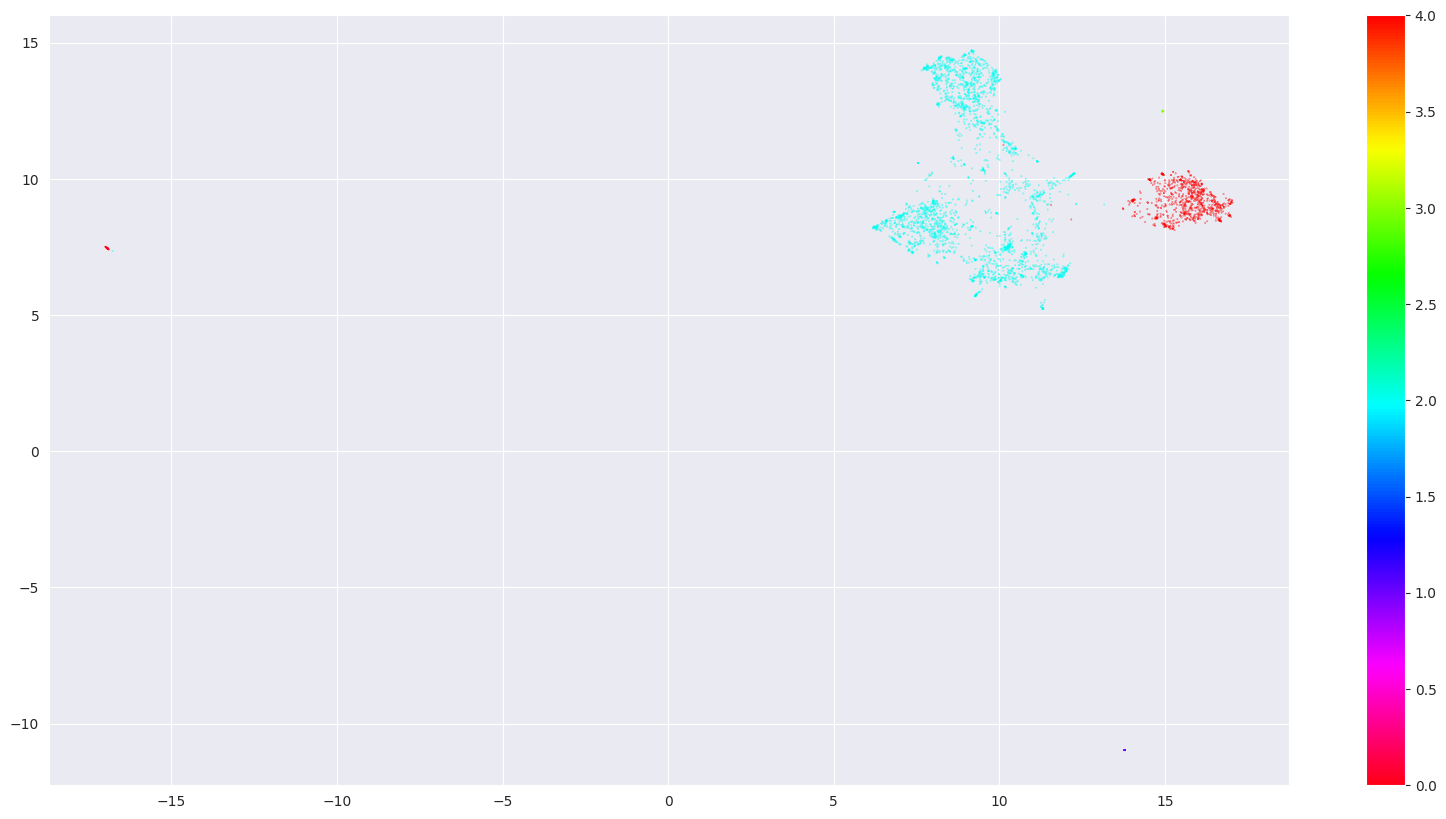

In [37]:
import matplotlib.pyplot as plt

# Prepare data
umap_vis_data = umap.UMAP(n_neighbors=15,
                      n_components=2,
                      min_dist=0.0,
                      metric='cosine').fit_transform(embedded_text)
df_umap_vis = pd.DataFrame(umap_vis_data, columns=['x', 'y'])
df_umap_vis['label'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = df_umap_vis.loc[df_umap_vis.label == -1, :]
clustered = df_umap_vis.loc[df_umap_vis.label != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.label, s=0.05, cmap='hsv_r')
plt.colorbar()

#5. Extract topics from clusters

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel

In [39]:
df

,text,label,cluster
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",comp.windows.x,2
25,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this? How much, to attend????\n\nAnyone want to go?",sci.space,2
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",comp.windows.x,2
33,\nBe patient. He has a sore shoulder from crashing into the wall.\nThe Cards will give him all the time he needs to come around.\nHe is their full time centerfielder.\nHe will not however steal as often this year as he is hitting\nclean-up.,rec.sport.baseball,4
37,\n\tProof that the entire private sector is vastly more inefficient?\n\n\n\tBlue Cross is the government health insurance provider.\n\n\tOops.\n\n\t[Ads for Z magazine deleted to Save the Earth],talk.politics.misc,2
...,...,...,...
18808,"Can someone send me ticket ordering information for the\nfollowing teams: Baltimore, Philadelphia and Boston.\n\nAlso, if you have a home schedule available - can you tell me the dates\nfor all home games between July26-Aug6 and between Aug30-Sept10 and if\nany of these games are promotion nights or special discount nights?\n\nThanks !!! Ron\n\nPS: and also who the opponents are for these games :-)\n\nDo NOT reply to this account,\nplease reply to: ronc@vnet.ibm.com",rec.sport.baseball,4
18817,\nWhatever happened to uwm? Is it still available in some form? It's\nbeen years since I used it or heard anyone talk about it.\n--,comp.windows.x,2
18824,"\nYou have to do the same sorts of things that Xt does with its main loop.\nThat is, you have to rig up a timer queue, and you have to put a \nselect(2) or poll(2) call in your main loop. You can obtain the \nfile descriptor of the X display connection using \n fd = ConnectionNumber (display);",comp.windows.x,2
18827,"On 21 Apr 93 00:07:20 GMT, Theodore A. Kaldis observed:\n\n: > because if she heard\n: Thankfully, you got the gender right. For I am not a deviant.\n\nBigots aren't classified as deviants? How sad.\n\n: > how disparaging you are towards political minorities,\n: Sexual deviants do not comprise a ""political minorit[y]"".\n\nSo, what's this I hear about a March on Washington...assuming\nyou are still considering homosexuality and bisexuality\nas subsets of ""sexual deviants?""\n\n: > and if she had any shred of self-respect, she'd be out the door.\n: I only associate with girls who do indeed have self-respect. \n\nI trust that many self-respecting *women* might take some sort\nof offense to your use of the term ""girls"" in the above sentence.\n\n--\nMichael D. Adams (starowl@a2i.rahul.net) Enterprise, Alabama",talk.politics.misc,2


In [42]:
df['cluster'].value_counts()

2    2790
4     852
0      69
1      18
3      15
Name: cluster, dtype: int64

In [43]:
df['label'].value_counts()

rec.sport.baseball    994
comp.windows.x        988
sci.space             987
talk.politics.misc    775
Name: label, dtype: int64

In [44]:
cluster_labels =df['cluster'].unique()

group all documents/samples into cluster

In [45]:
df_topic_doc = df.groupby(['cluster']).agg({'text': ' '.join})
print(df_topic_doc.shape)
print(type(df_topic_doc.head()))
df_topic_doc['label']= cluster_labels
df_topic_doc.columns

(5, 1)
<class 'pandas.core.frame.DataFrame'>


Index(['text', 'label'], dtype='object')

In [46]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#vectorizer = CountVectorizer(preprocessor=clean_text,
#                             min_df=3,
#                             stop_words="english")
vectorizer = CountVectorizer(stop_words="english"
                            )
vect=vectorizer.fit_transform(df_topic_doc['text'])
print(type(vect))
print(type(vectorizer))

df_example = pd.DataFrame(data=vect.toarray(),
                          columns = vectorizer.get_feature_names_out())
print(df_example.shape)
df_example



<class 'scipy.sparse._csr.csr_matrix'>
<class 'sklearn.feature_extraction.text.CountVectorizer'>
(5, 38916)


,00,000,0000,00000,000000,00000000,00000074,00000093,000000e5,000005102000,00000510200001,00000ee5,000010af,000062david42,0001mpc,00041032,0004136,00041555,0004244402,0004246,00043819,0004422,00044513,00044808,00044939,...,zuma,zumwalt,zupcic,zurbrin,zv,zvezdny,zvl1,zvn,zw,zwaartepunten,zwak,zwakke,zware,zwarte,zwork,zx,zx7ig,zy,zy7,zy8,zylorq,zymos,zz,zzc6,zzzzzzt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,197,164,3,8,1,2,4,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,...,2,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0
3,189,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2,0,1,1,3,1,1,1,1,2,0,4,1,2,1,1,1,0,2,1,0
4,12,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [47]:
df_example #get rid of digit?

,00,000,0000,00000,000000,00000000,00000074,00000093,000000e5,000005102000,00000510200001,00000ee5,000010af,000062david42,0001mpc,00041032,0004136,00041555,0004244402,0004246,00043819,0004422,00044513,00044808,00044939,...,zuma,zumwalt,zupcic,zurbrin,zv,zvezdny,zvl1,zvn,zw,zwaartepunten,zwak,zwakke,zware,zwarte,zwork,zx,zx7ig,zy,zy7,zy8,zylorq,zymos,zz,zzc6,zzzzzzt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,197,164,3,8,1,2,4,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,...,2,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0
3,189,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2,0,1,1,3,1,1,1,1,2,0,4,1,2,1,1,1,0,2,1,0
4,12,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


About baseball

In [48]:
df_example.iloc[4].sort_values(ascending=False)[:20]

year        481
game        416
team        314
think       307
don         306
good        290
games       263
time        253
like        251
just        248
baseball    245
hit         243
players     217
better      216
runs        187
know        174
season      163
league      162
win         159
did         157
Name: 4, dtype: int64

About drug

In [51]:
df_example.iloc[2].sort_values(ascending=False)[:20]

space        1382
people       1171
like         1132
use          1126
don          1122
just         1055
know          998
think         996
time          926
program       852
file          811
window        808
edu           788
new           719
does          716
president     713
make          709
mr            644
server        632
way           623
Name: 2, dtype: int64

About religion

In [52]:
df_example.iloc[1].sort_values(ascending=False)[:20]

export         1
pub            1
mit            1
edu            1
maf            1
lcs            1
sunkbd         1
930314         1
tar            1
00             0
penetrate      0
penetration    0
penetrators    0
penguins       0
penguin        0
pending        0
penicilin      0
penicillin     0
peninsula      0
penna          0
Name: 1, dtype: int64

Show cluster tf idf + a look at the size of the clusters

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range,
                            stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

#tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

#6. Cluster evaluation

#7.Conclusions







In [ ]:
############################# END OF SCRIPT ###################################